#### Import useful libraries

In [1]:
import numpy as np

import h5py
import pickle

import MDAnalysis as mda
from MDAnalysis import analysis

import importlib
import XS_calc
from XS_calc import *

import XS_ga
from XS_ga import *

import matplotlib.pyplot as plt
# %matplotlib notebook
# %matplotlib inline


C:\Users\achan\anaconda3\lib\site-packages\MDAnalysis\coordinates\chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


#### Reload XS_calc

In [ ]:
importlib.reload(XS_calc) # This reloads XS_calc
from XS_calc import *     # This updates the functions in XS_calc

#### Import experimental files for 1l2y

In [2]:
filename = "data/20220404_trpcage_reconstructed_saxs.h5"
h5 = h5py.File(filename)
print(h5.keys())

<KeysViewHDF5 ['q_SAD', 's_SAD', 's_SAD_err', 's_int', 's_int_err', 's_unf', 's_unf_err']>


In [3]:
# Set measurement q to experimental q
mea = Measurement(q = np.squeeze(h5['q_SAD'][:]))
print(np.shape(mea.q))

(136,)


In [4]:
# Create Experiment class objects for each species
F_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][0,:]), S_err = np.squeeze(h5['s_SAD_err'][0,:]))
U_st = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_SAD'][1,:]), S_err = np.squeeze(h5['s_SAD_err'][1,:]))
I_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_int'][:]), S_err = np.squeeze(h5['s_int_err'][:]))
U_tr = Experiment(q=np.squeeze(h5['q_SAD'][:]), S_exp = np.squeeze(h5['s_unf'][:]), S_err = np.squeeze(h5['s_unf_err'][:]))

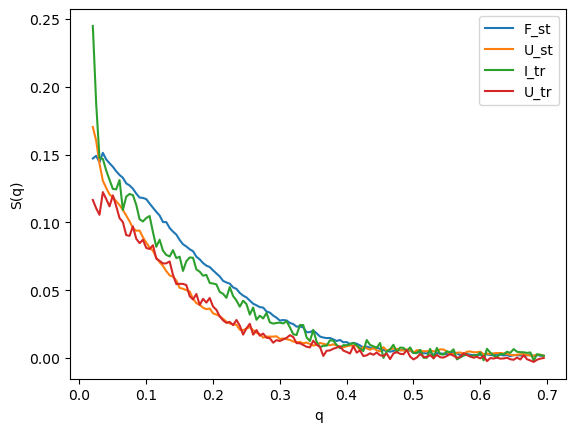

In [5]:
plt.figure()
plt.plot(F_st.q, F_st.S_exp, label="F_st")
plt.plot(U_st.q, U_st.S_exp, label="U_st")
plt.plot(I_tr.q, I_tr.S_exp, label="I_tr")
plt.plot(U_tr.q, U_tr.S_exp, label="U_tr")
plt.xlabel('q')
plt.ylabel('S(q)')
plt.legend()
plt.show()

#### Import the MD trajectory and perform XS calculation on trajectory

In [ ]:
# This would be a typical use case

U = mda.Universe("data/1l2y_eq_300K.psf", "data/1l2y_eq_300K.dcd")

# full trajectory
# traj = traj_slice(U, selection='protein')

# first 100 frames
# traj = Trajectory_slice(U, selection="protein", frame_max = 10)

# This doesn't work yet... OverflowError: Python int too large to convert to C long
# every 50 frames
traj = Trajectory_slice(U, selection="protein", frame_min=0, frame_step=10, ffdir='form_factors/')

print(np.shape(traj.Frames))

env = Environment()

# XS = traj_calc(traj, env, mea)
# print(np.shape(XS))
# Do something with XS. E.g. fitting etc.


#### Compute for every c1 / c2 permutaion the XS_calc of every structure

In [6]:
from itertools import product

In [7]:
c1_grid = np.arange(0.98, 1.051, 0.01)
c2_grid = np.arange(0.0, 4.01, 0.2)
c1c2_product = list(product(c1_grid, c2_grid))
print(len(c1c2_product))

168


In [ ]:
# This takes a very long time. Better dump the XS_pool at the end and load when you resume analysis
XS_pool = {}
for c1c2 in c1c2_product:
    print(f'Condition: {c1c2}', end=' ')
    c1, c2 = c1c2
    env = Environment(c1=c1, c2=c2)
    XS_pool[c1c2] = traj_calc(traj, env, mea, method='frame_XS_calc_fast')

### c search traj calc output analysis

In [8]:
# from 06/21/2022
# pickle.dump(XS_pool, open('data/1l2y_unfold_500K_XS.pkl', 'wb'))
# XS_pool = pickle.load(open('data/1l2y_unfold_500K_XS.pkl','rb'))

# from 10/31/2022
# pickle.dump(XS_pool, open('data/1l2y_eq_300K_XS.pkl', 'wb'))
XS_pool = pickle.load(open('data/1l2y_eq_300K_XS.pkl','rb'))

# test = pickle.load(open('data/1l2y_F_GA_pool_20220606.pkl', 'rb'))

# XS_pool = pickle.load(open('data/1l2y_REST2_XS_20220527.pkl', 'rb'))

In [ ]:
XS_one = XS_pool[(1.04, 0.2)]
print(np.shape(XS_one))

In [ ]:
plt.figure()
plt.plot(mea.q, np.transpose(XS_one))
plt.show()

In [9]:
XS_pool_F = XS_pool[c1c2_product[150]]
XS_pool_Itr = XS_pool[c1c2_product[147]]
XS_pool_Utr = XS_pool[c1c2_product[147]]
print(np.shape(XS_pool_F))
print(np.shape(XS_pool_Itr))
print(np.shape(XS_pool_Utr))

(1001, 136)
(1001, 136)
(1001, 136)


In [ ]:
print(c1c2_product[150])

In [10]:
# Delete the whole XS_pool
del XS_pool

In [ ]:
GA_pool_F = [GeneticAlgorithm(XS_pool_F, F_st.S_exp, F_st.S_err, label=str(x),
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in np.arange(10)]

print(np.shape(GA_pool_F))

In [11]:
GA_pool_Utr = [GeneticAlgorithm(XS_pool_Utr, U_tr.S_exp, U_tr.S_err, label=str(x),
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in np.arange(10)]

print(np.shape(GA_pool_Utr))

(10,)


In [12]:
pool = mp.Pool(4)
GA_pool_Utr = pool.map(fit_pool, zip(GA_pool_Utr, [5000]*len(GA_pool_Utr)))
pool.close()
pool.join()

In [14]:
# Set up GA pool for Itr
# c, 2000n, 10r  
GA_pool_Itr = [GeneticAlgorithm(XS_pool_Itr[:,3:], I_tr.S_exp[3:], I_tr.S_err[3:], label=str(x),
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in np.arange(10)]

print(np.shape(GA_pool_Itr))

(10,)


In [15]:
pool = mp.Pool(4)
GA_pool_Itr = pool.map(fit_pool, zip(GA_pool_Itr, [5000]*len(GA_pool_Itr)))
pool.close()
pool.join()

In [16]:
# save_ga_pool_h5(GA_pool_F, "1l2y_F_GA_50c_5kn_10r.h5")
# save_ga_pool_h5(GA_pool_Utr, "1l2y_Utr_GA_50c_5kn_10r.h5")
save_ga_pool_h5(GA_pool_Itr, "1l2y_Itr_GA_50c_5kn_10r.h5")

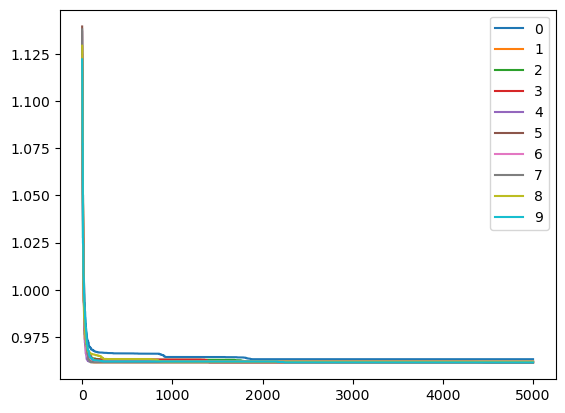

In [17]:
plt.figure()
for x in np.arange(10):
  plt.plot(GA_pool_Itr[x].fitness_trace, label=str(x))
plt.legend()
plt.show()

In [ ]:

import multiprocessing as mp
import time

def fit_chromosome(chromosome):
    chromosome.fit()
    return chromosome

class Chromosome:
    
    def __init__(self, pool_options=None, n_genes=50, gene_indices=None):
        self.n_genes = n_genes
        self.gene_indices = gene_indices
        self.fitness = np.inf
        self.pool_option = None
        self.is_survivor = False
        self.expression = None
        self.res = None
        
    def fit(self, gene_data, target_data, target_err):
        

        gene_avg = np.mean(gene_data, axis=0)
        chi2_fun = lambda x: np.sqrt(np.mean( (((gene_avg * x[0] + x[1]) - target_data) / target_err)**2 ))
        res = minimize(chi2_fun, (target_data[0] / gene_avg[0] ,0), method='Nelder-Mead')
        self.fitness = res.fun
        self.res = res
        return res

        
    def assign(self, pool_option=None, fitness=None, is_survivor=None, res=None):
        if pool_option is not None:
            self.pool_option = pool_option
        if fitness is not None:
            self.fitness = fitness
        if is_survivor is not None:
            self.is_survivor = is_survivor
        if res is not None:
            self.res = res
        
    def individual_gene_data(self, gene_data):
#         if self.pool_option is not None:
#             gene_data = self.gene_pool[self.pool_option][self.gene_indices]
#         else:
#             gene_data = self.gene_pool[self.gene_indices]
        return (np.mean(gene_data * self.res.x[0] + self.res.x[1], axis=0), gene_data * self.res.x[0] + self.res.x[1])

    
class GeneticAlgorithm:
    
    def __init__(self, gene_pool, target_data, target_err=None, label=None,
                 n_chromosomes=150, n_survive=50, n_mutate=50, n_cross=50, n_genes=50):
        # Gene pool is the "data", an nD numpy array, or a dict of such
        # If a dict, then different keys of the dict are considered pool options
        # Every pool option must have the same number of gene pools
        self.gene_pool = gene_pool
        self.label = label
        self.pool_options = None
        self.pool_length = None
        self.n_chromosomes = n_chromosomes
        self.n_survive = n_survive
        self.n_mutate = n_mutate
        self.n_cross = n_cross
        self.n_genes = n_genes
        if self.n_chromosomes != self.n_survive + self.n_mutate + self.n_cross:
            self.n_chromosomes = self.n_survive + self.n_mutate + self.n_cross
        self.best_fitness = np.inf
        self.fitness_trace = []
        
        if type(gene_pool) == dict:
            self.pool_options = list(gene_pool.keys())
            # Check that within all options the gene pools are the same length
            pool_length_each_options = np.array([len(self.gene_pool[key]) for key in self.pool_options])
            if not np.all(pool_length_each_options == pool_length_each_options[0]):
                print("Warning: Not all pool options have the same number of genes")
            self.pool_length = pool_length_each_options[0]
            # Register options, makesure within all options the gene pools are the same length
        elif type(gene_pool) == list or type(gene_pool) == np.ndarray:
            self.pool_length = len(gene_pool)
        
        
        # Process data
        self.target_data = target_data
        if target_err is None:
            self.target_err = np.ones_like(self.target_data)
        else:
            self.target_err = target_err
        
        # Create chromosomes
        self.chromosome_pool = []
        for _ in range(self.n_chromosomes):
            self.chromosome_pool.append(Chromosome(n_genes=self.n_genes,
                                                   gene_indices=np.random.choice(range(self.pool_length), n_genes)))

        self.evolution_round = 0
        self.evolution_checkpoint = 0


    def report(self):
        print(f'This genetic algorithm: {len(self.chromosome_pool)} chromosomes, each with {self.n_genes} genes')
        print(f'For evolution, keep {self.n_survive}, mutate {self.n_mutate}, and cross {self.n_cross} chromosomes')
        
        
    def evolve(self, n=1, use_mp=False, silence=False, report_progress=True):
        # Calculate fit of every chromosome
        t0 = time.time()
        for round_counter in range(n):
            t1 = time.time()
            if t1 - t0 > 10:
                print(f'Progress for {self.label}: Round {round_counter + self.evolution_checkpoint}, best fit: {self.best_fitness}')
                t0 = t1
            if not silence:
                print(f'Round {round_counter + self.evolution_checkpoint}, processing chromosomes ...')
            fitness = np.zeros(self.n_chromosomes)
            if use_mp:
#                 raise NotImplementedError('Currently not working')
                self.fit_all_mp()
            else:
                self.fit_all()
            for idx, chromosome in enumerate(self.chromosome_pool):
                fitness[idx] = chromosome.fitness
            # Sort fitness
            fitness_rank = np.argsort(fitness)
            survivors = [self.chromosome_pool[x] for x in fitness_rank[:self.n_survive]]
            for survivor in survivors:
                survivor.assign(is_survivor=True)
            mutated = []
            crossed = []
            for chromosome in survivors:
                mutated.append(self.mutate(chromosome))
                crossed.append(self.cross(chromosome))
            self.chromosome_pool = survivors + mutated + crossed
            self.best_fitness = np.min(fitness)
            self.fitness_trace.append(np.min(fitness))
            if not silence:
                if self.pool_options is not None:
                    print(f'Best fit is: {np.min(fitness)} at {survivors[0].pool_option}')
                else:
                    print(f'Best fit is: {np.min(fitness)} for {self.label}')
            self.evolution_round += 1
        self.evolution_checkpoint = self.evolution_round
        print(f"Done with evolution for {self.label}, best fit: {self.best_fitness}")
        
    def fit_all(self):
        for idx, chromosome in enumerate(self.chromosome_pool):
#             if idx % 10 == 9:
#                 print(f'{idx+1}', end=' ')
            _ = self.fit_one(chromosome)
            
    def fit_all_mp(self):
        print('using multiprocessing', end=' ')
        pool = mp.Pool(4)
        res = pool.map(self.fit_one, self.chromosome_pool)
        pool.close()
        pool.join()
        self.chromosome_pool = res
        
    def fit_one(self, chromosome):
        if self.pool_options is None:
            if not chromosome.is_survivor:
                chromosome.fit(self.gene_pool[chromosome.gene_indices], self.target_data, self.target_err)
        else:
            if not chromosome.is_survivor:
                sub_chi2 = np.inf
                sub_option = None
                sub_res = None
                for pool_option in self.pool_options:
                    chromosome.fit(self.gene_pool[pool_option][chromosome.gene_indices], self.target_data, self.target_err)
                    chi2_this = chromosome.res.fun
                    res_this = chromosome.res
                    if chi2_this < sub_chi2:
                        sub_chi2 = chi2_this
                        sub_option = pool_option
                        sub_res = res_this
                chromosome.assign(fitness=sub_chi2, pool_option=sub_option, res=sub_res)
        return chromosome
                    
                    
    
    def mutate(self, chromosome):
        n_old_genes = np.ceil(chromosome.n_genes * 0.8).astype(int)
        n_new_genes = chromosome.n_genes - n_old_genes
        old_genes = np.random.choice(chromosome.gene_indices, n_old_genes, replace=False)
        new_genes = np.random.choice(self.pool_length, n_new_genes)
        new_chromosome = Chromosome(n_genes=self.n_genes,
                                    gene_indices=np.concatenate((old_genes, new_genes)))
        
        return new_chromosome
    
    def cross(self, chromosome):
        other_chromosome = np.random.choice(self.chromosome_pool, 1)[0]
        combined_genes = np.concatenate((chromosome.gene_indices, other_chromosome.gene_indices))
        new_genes = np.random.choice(combined_genes, self.n_genes)
        new_chromosome = Chromosome(n_genes=self.n_genes,
                                    gene_indices=new_genes)
        
        return new_chromosome

    def get_best_fit(self):
        if self.pool_options is not None:
            best_data = self.gene_pool[self.chromosome_pool[0].pool_option][self.chromosome_pool[0].gene_indices]
            best_data = self.chromosome_pool[0].individual_gene_data(best_data)
        else:
            best_data = self.gene_pool[self.chromosome_pool[0].gene_indices]
            best_data = self.chromosome_pool[0].individual_gene_data(best_data)
        return best_data

In [ ]:
# single genetic algorithm run
ga = GeneticAlgorithm(XS_pool[(1.04, 0.0)], F_st.S_exp, F_st.S_err, 
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50)

In [ ]:
ga.report()

In [ ]:
ga.evolve(n=100, use_mp=False, silence=False)

In [ ]:
plt.figure()
bf = ga.get_best_fit()

plt.plot(mea.q, bf[1].T, color='tab:gray', alpha=0.2)
plt.plot(mea.q, bf[0])
plt.errorbar(F_st.q, F_st.S_exp, F_st.S_err)

print(ga.chromosome_pool[0].res.x)

In [ ]:
# Multiple genetic algorithm runs

key_sel = list(XS_pool.keys())

F_GA_pool = [GeneticAlgorithm(XS_pool[x], F_st.S_exp, F_st.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]

def fit_pool(obj):
    GA, n = obj
    GA.evolve(n, silence=True)
    return GA

In [ ]:
pickle.dump(key_sel, open('1l2y_GA_pool_keysel_20220611.pkl', 'wb'))

In [ ]:
test_ks = pickle.load(open('1l2y_GA_pool_keysel_20220611.pkl','rb'))

In [ ]:
print(test_ks[0])

In [ ]:
pool = mp.Pool(8)
F_GA_pool = pool.map(fit_pool, zip(F_GA_pool, [50]*len(F_GA_pool)))
pool.close()
pool.join()

In [ ]:
key_sel = list(XS_pool.keys())

U_GA_pool = [GeneticAlgorithm(XS_pool[x], U_st.S_exp, U_st.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]


In [ ]:
pool = mp.Pool(8)
U_GA_pool = pool.map(fit_pool, zip(U_GA_pool, [50]*len(U_GA_pool)))
pool.close()
pool.join()

In [ ]:
key_sel = list(XS_pool.keys())

Itr_GA_pool = [GeneticAlgorithm(XS_pool[x], I_tr.S_exp, I_tr.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]


In [ ]:
pool = mp.Pool(8)
Itr_GA_pool = pool.map(fit_pool, zip(Itr_GA_pool, [50]*len(Itr_GA_pool)))
pool.close()
pool.join()

In [ ]:
key_sel = list(XS_pool.keys())

Utr_GA_pool = [GeneticAlgorithm(XS_pool[x], U_tr.S_exp, U_tr.S_err, label=f'({x[0]:.2f}, {x[1]:.1f})',
                      n_genes=50, n_cross=50, n_mutate=50, n_survive=50) for x in key_sel]


In [ ]:
pool = mp.Pool(8)
Utr_GA_pool = pool.map(fit_pool, zip(Utr_GA_pool, [50]*len(Utr_GA_pool)))
pool.close()
pool.join()

In [ ]:
plt.figure(dpi=200)

# Change these to plot for different states
data = U_tr
mpools = Utr_GA_pool

plt.errorbar(data.q, data.S_exp, data.S_err, color='tab:red', linewidth = 0.8, elinewidth=0.6)
fitness_pile = [ga.best_fitness for ga in mpools]
fitness_rank = np.argsort(fitness_pile)
for ga_rank in fitness_rank[:8]:
    ga = mpools[ga_rank]
    bf = ga.get_best_fit()
    bl = ga.label + f', fit={ga.best_fitness:.4f}'

# plt.plot(mea.q, bf[1].T, color='tab:gray', alpha=0.2)
    plt.plot(mea.q, bf[0], label=bl)
    
# plt.yscale('log')
plt.legend(loc='best', fontsize=6)

# print(ga.chromosome_pool[0].res.x)